# Tréning CNN pre viactriednu klasifikáciu s využitím ResNet50

Architektúra a výsledky najlepšieho modelu: 
* Architektúra modelu z experimentu 5
* Výsledky modelu z experimentu 5

In [6]:
pip install h5py==3.7.0 astropy==6.1.4 parfive==2.1.0 Glymur==0.13.6 sunpy==6.0.3 numpy==1.24.4 hvpy==1.1.0 aiapy==0.7.4 opencv-python==4.10.0.84 ultralytics torch

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 40.8 MB/s eta 0:00:0000:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [33 lines of output]
      Traceback (most recent call last):
        File "/opt/conda/lib/python3.12/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 389, in <module>
          main()
        File "/opt/conda/lib/python3.12/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 373, in main
          json_out["return_val"] = hook(**hook_input["kwargs"])
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "/opt/conda/lib/python3.12/site-packages/pip/_vendor/pyproject_hooks/_in_proce

CNN sigmoid pokus 1 (ribbons), bez ResNet50

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns

# priecinky
base_folder = "./ribbons"
train_dir = os.path.join(base_folder, "train")
valid_dir = os.path.join(base_folder, "valid")
test_dir = os.path.join(base_folder, "test")

# data generator + augumentacie
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    brightness_range=(0.8, 1.3),
    preprocessing_function=lambda x: tf.image.adjust_contrast(x, np.random.uniform(0.7, 1.3)),
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)
validation_generator = test_datagen.flow_from_directory(
    valid_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# vahy tried
class_labels = list(train_generator.class_indices.keys())
class_counts = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_counts),
    y=class_counts
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Class weights:", class_weights_dict)

# CNN Model - sigmoid
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(class_labels), activation='sigmoid')  # Sigmoid multi-label klasifikacia
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # optimizer Adam
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    class_weight=class_weights_dict,
    callbacks=[early_stopping]
)

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# predikticie 
y_pred_prob = model.predict(test_generator)  # pravdepodobnosti zo sigmoid
y_true = test_generator.classes

# optimalny threshold s vyuzitim MCC
best_thresholds = []
for class_idx in range(len(class_labels)):
    best_mcc = -1
    best_thresh = 0.5  # defaultny threshold
    
    for threshold in np.arange(0, 1.01, 0.01):  # threshold od 0 do 1 s krokom 0.01
        y_pred_bin = (y_pred_prob[:, class_idx] > threshold).astype(int)
        mcc = matthews_corrcoef(y_true == class_idx, y_pred_bin)

        if mcc > best_mcc:
            best_mcc = mcc
            best_thresh = threshold

    best_thresholds.append(best_thresh)
    print(f"Najlepší threshold pre triedu {class_labels[class_idx]}: {best_thresh} (MCC: {best_mcc:.4f})")

# aplikacia tresholdu pre finalne predikcie
y_pred_bin = np.zeros_like(y_pred_prob, dtype=int)
for i, threshold in enumerate(best_thresholds):
    y_pred_bin[:, i] = (y_pred_prob[:, i] > threshold).astype(int)

# vyhodnotenie modelu
for i, class_name in enumerate(class_labels):
    print(f"Výsledky pre triedu {class_name}:")
    print(classification_report(y_true == i, y_pred_bin[:, i]))

    # confusion matrix
    cm = confusion_matrix(y_true == i, y_pred_bin[:, i])
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not ' + class_name, class_name], yticklabels=['Not ' + class_name, class_name])
    plt.title(f'Confusion Matrix for {class_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

model.save("cnn/ribbons_cnn_model_sigmoid_thresholds.h5")

2025-03-05 20:59:37.008672: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 23145 images belonging to 3 classes.
Found 2590 images belonging to 3 classes.
Found 6428 images belonging to 3 classes.
Class weights: {0: np.float64(0.37134193299961493), 1: np.float64(3.448815377738042), 2: np.float64(58.446969696969695)}


/opt/conda/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 682s 940ms/step - accuracy: 0.4648 - loss: 1.1267 - val_accuracy: 0.4683 - val_loss: 1.0278
Epoch 2/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 586s 809ms/step - accuracy: 0.2017 - loss: 1.1639 - val_accuracy: 0.4819 - val_loss: 1.0287
Epoch 3/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 557s 769ms/step - accuracy: 0.3049 - loss: 1.0782 - val_accuracy: 0.7359 - val_loss: 0.9717
Epoch 4/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 528s 729ms/step - accuracy: 0.4149 - loss: 1.0090 - val_accuracy: 0.1734 - val_loss: 1.2574
Epoch 5/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 542s 748ms/step - accuracy: 0.5446 - loss: 0.9384 - val_accuracy: 0.7819 - val_loss: 0.6870
Epoch 6/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 532s 735ms/step - accuracy: 0.6684 - loss: 0.8353 - val_accuracy: 0.7691 - val_loss: 0.6875
Epoch 7/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 540s 746ms/step - accuracy: 0.7157 - loss: 0.7465 - val_accuracy: 0.8425 - val_loss: 0.5227
Epoch 8/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 510s 705ms/step - accuracy: 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Found 6428 images belonging to 3 classes.


/opt/conda/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


201/201 ━━━━━━━━━━━━━━━━━━━━ 52s 259ms/step
Výsledky pre triedu C:
              precision    recall  f1-score   support

       False       0.60      0.12      0.20       655
        True       0.91      0.99      0.95      5773

    accuracy                           0.90      6428
   macro avg       0.75      0.56      0.57      6428
weighted avg       0.88      0.90      0.87      6428



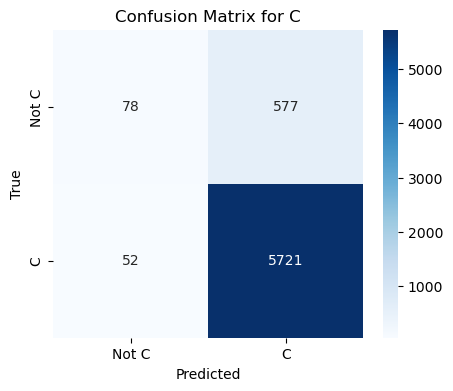

Výsledky pre triedu M:
              precision    recall  f1-score   support

       False       0.95      0.13      0.24      5817
        True       0.10      0.94      0.18       611

    accuracy                           0.21      6428
   macro avg       0.53      0.54      0.21      6428
weighted avg       0.87      0.21      0.23      6428



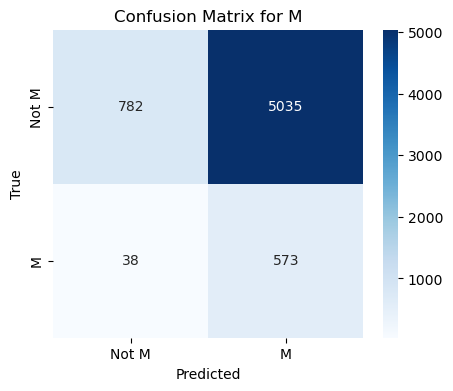

Výsledky pre triedu X:
              precision    recall  f1-score   support

       False       0.99      0.99      0.99      6384
        True       0.20      0.23      0.21        44

    accuracy                           0.99      6428
   macro avg       0.60      0.61      0.60      6428
weighted avg       0.99      0.99      0.99      6428



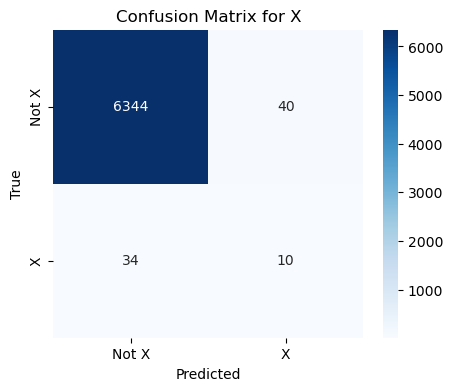

In [2]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns

# Načítanie uloženého modelu
model = load_model("cnn/ribbons_cnn_model_sigmoid_thresholds.h5", compile=False)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

test_dir = "./ribbons/test"

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # musi byt vypnute, aby poradie zodpovedalo y_true
)

class_labels = list(test_generator.class_indices.keys())  # nazvy tried

# predikcia na testovacích dátach
y_pred_prob = model.predict(test_generator)  # pravdepodobnosti zo sigmoid
y_true = test_generator.classes  # skutocne triedy

# ynova nastavíme optimálne thresholdy (rovnaké ako pri trénovaní)
best_thresholds = [0.5, 0.5, 0.5]  

# nastavenie optimalnych tresholdov pre predik
y_pred_bin = np.zeros_like(y_pred_prob, dtype=int)
for i, threshold in enumerate(best_thresholds):
    y_pred_bin[:, i] = (y_pred_prob[:, i] > threshold).astype(int)

# Vyhodnotenie
for i, class_name in enumerate(class_labels):
    print(f"Výsledky pre triedu {class_name}:")
    print(classification_report(y_true == i, y_pred_bin[:, i]))

    # Confusion matrix pre kazdu triedu
    cm = confusion_matrix(y_true == i, y_pred_bin[:, i])
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not ' + class_name, class_name], yticklabels=['Not ' + class_name, class_name])
    plt.title(f'Confusion Matrix for {class_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# <span style="color:green">Architektúra modelu z EXPERIMENTU 5</span>  

sigmoid + resnet50, MCC

In [10]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns

# priečinky obrázkov
base_folder = "./ribbons"
train_dir = os.path.join(base_folder, "train")
valid_dir = os.path.join(base_folder, "valid")
test_dir = os.path.join(base_folder, "test")

# data augmentation pre lepšiu generalizáciu
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    brightness_range=(0.7, 1.3),
    preprocessing_function=lambda x: tf.image.adjust_contrast(x, np.random.uniform(0.7, 1.3)),
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# generátory dát
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(224, 224), 
    batch_size=32, 
    class_mode='categorical'
)
validation_generator = test_datagen.flow_from_directory(
    valid_dir, 
    target_size=(224, 224), 
    batch_size=32, 
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_dir, 
    target_size=(224, 224), 
    batch_size=32, 
    class_mode='categorical', 
    shuffle=False
)

# class weights - lepšie vybalansované váhy tried
class_labels = list(train_generator.class_indices.keys())
class_counts = train_generator.classes
class_weights = compute_class_weight('balanced', classes=np.unique(class_counts), y=class_counts)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Class weights:", class_weights_dict)

# použitie predtrénovaného modelu ResNet50
base_model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # používame ako extraktor príznakov

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # pooling vrstva
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(len(class_labels), activation='sigmoid')  # Sigmoid pre multi-label klasifikáciu
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Early stopping na základe validačnej chyby
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# tréning modelu
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    class_weight=class_weights_dict,
    callbacks=[early_stopping]
)

# evaluácia modelu
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# predikcie modelu
y_pred_prob = model.predict(test_generator)
y_true = test_generator.classes

# optimalizácia thresholdov pomocou MCC
best_thresholds = []
for class_idx in range(len(class_labels)):
    best_mcc = -1
    best_thresh = 0.5  # default threshold
    
    for threshold in np.arange(0, 1.01, 0.01):  # threshold od 0 do 1 s krokom 0.01
        y_pred_bin = (y_pred_prob[:, class_idx] > threshold).astype(int)
        mcc = matthews_corrcoef(y_true == class_idx, y_pred_bin)

        if mcc > best_mcc:
            best_mcc = mcc
            best_thresh = threshold

    best_thresholds.append(best_thresh)
    print(f"Najlepší threshold pre triedu {class_labels[class_idx]}: {best_thresh} (MCC: {best_mcc:.4f})")

# Použitie optimálnych thresholdov
y_pred_bin = np.zeros_like(y_pred_prob, dtype=int)
for i, threshold in enumerate(best_thresholds):
    y_pred_bin[:, i] = (y_pred_prob[:, i] > threshold).astype(int)

# Vyhodnotenie modelu
for i, class_name in enumerate(class_labels):
    print(f"\n **Výsledky pre triedu {class_name}:**")
    print(classification_report(y_true == i, y_pred_bin[:, i]))

    # Confusion matrix pre každú triedu
    cm = confusion_matrix(y_true == i, y_pred_bin[:, i])
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not ' + class_name, class_name], yticklabels=['Not ' + class_name, class_name])
    plt.title(f'Confusion Matrix for {class_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Uloženie modelu
model.save("cnn/ribbons_cnn_resnet_sigmoid_thresholds.h5")

Found 23145 images belonging to 3 classes.
Found 2590 images belonging to 3 classes.
Found 6428 images belonging to 3 classes.
Class weights: {0: np.float64(0.37134193299961493), 1: np.float64(3.448815377738042), 2: np.float64(58.446969696969695)}
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step 


/opt/conda/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 808s 1s/step - accuracy: 0.3745 - loss: 0.7088 - val_accuracy: 0.0811 - val_loss: 0.5982
Epoch 2/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 768s 1s/step - accuracy: 0.3648 - loss: 0.6314 - val_accuracy: 0.5429 - val_loss: 0.6022
Epoch 3/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 779s 1s/step - accuracy: 0.3797 - loss: 0.6395 - val_accuracy: 0.0811 - val_loss: 0.6404
Epoch 4/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 775s 1s/step - accuracy: 0.3026 - loss: 0.6412 - val_accuracy: 0.0147 - val_loss: 0.6773
Epoch 5/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 765s 1s/step - accuracy: 0.3175 - loss: 0.6564 - val_accuracy: 0.5444 - val_loss: 0.5902
Epoch 6/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 768s 1s/step - accuracy: 0.3564 - loss: 0.6499 - val_accuracy: 0.9004 - val_loss: 0.5709
Epoch 7/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 813s 1s/step - accuracy: 0.4935 - loss: 0.6204 - val_accuracy: 0.0147 - val_loss: 0.6910
Epoch 8/100
724/724 ━━━━━━━━━━━━━━━━━━━━ 771s 1s/step - accuracy: 0.2969 - loss: 0.6533 - 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Výsledky CNN pre jednotlivé triedy C, M a X

Found 6451 images belonging to 3 classes.


/opt/conda/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


202/202 ━━━━━━━━━━━━━━━━━━━━ 83s 404ms/step
 Najlepší threshold pre triedu C: 0.34 (MCC: 0.3717)
 Najlepší threshold pre triedu M: 0.33 (MCC: 0.2868)
 Najlepší threshold pre triedu X: 0.38 (MCC: 0.5728)

**Výsledky pre triedu C:**
              precision    recall  f1-score   support

       False       0.69      0.24      0.36       678
        True       0.92      0.99      0.95      5773

    accuracy                           0.91      6451
   macro avg       0.80      0.61      0.65      6451
weighted avg       0.89      0.91      0.89      6451



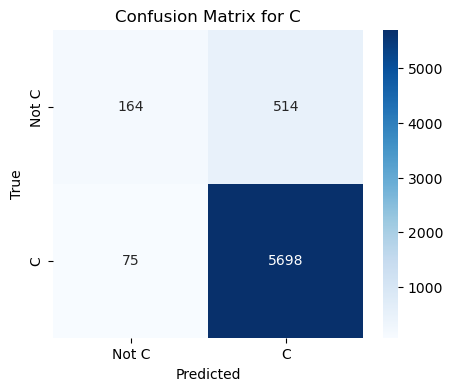


**Výsledky pre triedu M:**
              precision    recall  f1-score   support

       False       0.93      0.93      0.93      5820
        True       0.36      0.36      0.36       631

    accuracy                           0.87      6451
   macro avg       0.64      0.64      0.64      6451
weighted avg       0.87      0.87      0.87      6451



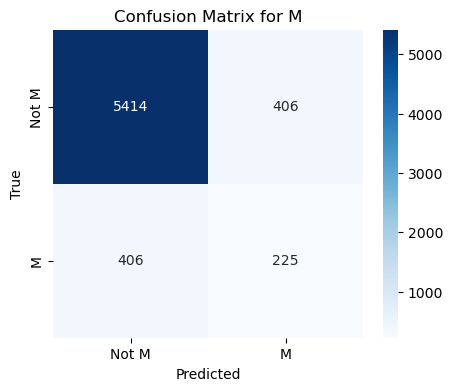


**Výsledky pre triedu X:**
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      6404
        True       0.65      0.51      0.57        47

    accuracy                           0.99      6451
   macro avg       0.82      0.75      0.78      6451
weighted avg       0.99      0.99      0.99      6451



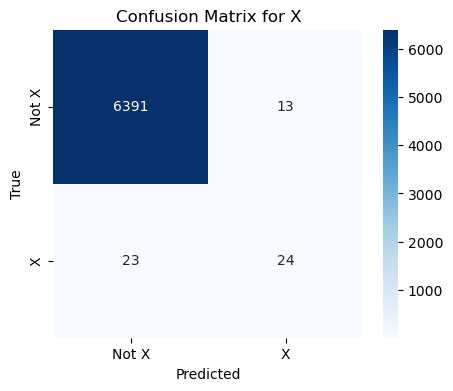

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns

# tetsovaci dataset
base_folder = "./ribbons"
test_dir = os.path.join(base_folder, "test")

# načítanie modelu
model = load_model("cnn/ribbons_cnn_resnet_sigmoid_thresholds.h5", compile=False)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# načítanie testovacích dát
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # zachovanie poradia obrázkov
)

# získanie názvov tried
class_labels = list(test_generator.class_indices.keys())

# predikcie modelu
y_pred_prob = model.predict(test_generator)  # pravdepodobnosti sigmoid
y_true = test_generator.classes  # skutočné triedy

# optimalizácia thresholdov pomocou MCC
best_thresholds = []
for class_idx in range(len(class_labels)):
    best_mcc = -1
    best_thresh = 0.5  # defaultny threshold
    
    for threshold in np.arange(0, 1.01, 0.01):  # skusam thresholdy od 0 do 1 s krokom 0.01
        y_pred_bin = (y_pred_prob[:, class_idx] > threshold).astype(int)
        mcc = matthews_corrcoef(y_true == class_idx, y_pred_bin)

        if mcc > best_mcc:
            best_mcc = mcc
            best_thresh = threshold

    best_thresholds.append(best_thresh)
    print(f" Najlepší threshold pre triedu {class_labels[class_idx]}: {best_thresh} (MCC: {best_mcc:.4f})")

#  pouzitie optimálnych thresholdov na finálne predikcie
y_pred_bin = np.zeros_like(y_pred_prob, dtype=int)
for i, threshold in enumerate(best_thresholds):
    y_pred_bin[:, i] = (y_pred_prob[:, i] > threshold).astype(int)

# vyhodnotenie modelu pre každú triedu zvlášť
for i, class_name in enumerate(class_labels):
    print(f"\n**Výsledky pre triedu {class_name}:**")
    print(classification_report(y_true == i, y_pred_bin[:, i]))

    #  Confusion matrix pre každú triedu
    cm = confusion_matrix(y_true == i, y_pred_bin[:, i])
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not ' + class_name, class_name], yticklabels=['Not ' + class_name, class_name])
    plt.title(f'Confusion Matrix for {class_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# hľadanie tresholdov + vizualizácia

Found 6451 images belonging to 3 classes.


/opt/conda/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


202/202 ━━━━━━━━━━━━━━━━━━━━ 108s 528ms/step
Najlepší threshold pre triedu C: 0.34 (MCC: 0.3717)


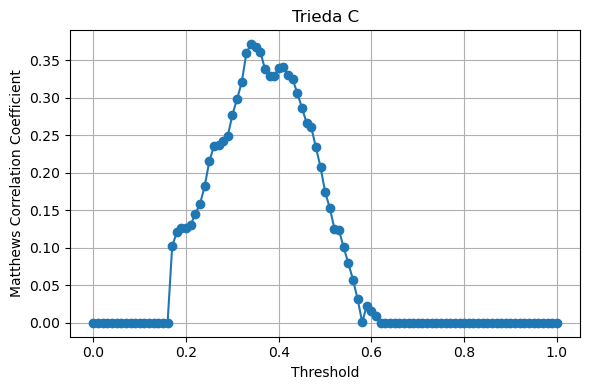

Najlepší threshold pre triedu M: 0.33 (MCC: 0.2868)


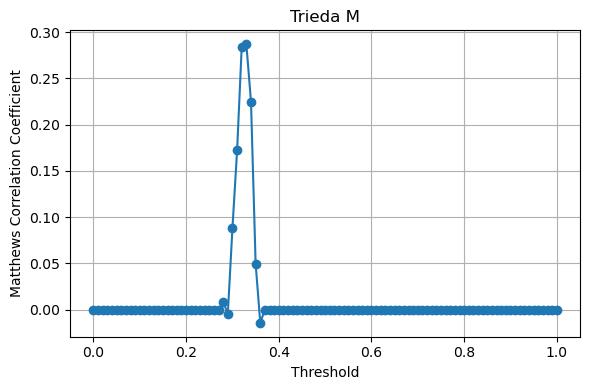

Najlepší threshold pre triedu X: 0.38 (MCC: 0.5728)


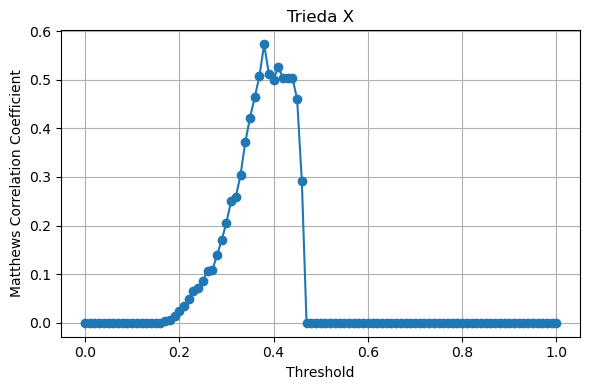

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns

# Nastavenie cesty k testovaciemu datasetu
base_folder = "./ribbons"
test_dir = os.path.join(base_folder, "test")

# Načítanie modelu
model = load_model("cnn/ribbons_cnn_resnet_sigmoid_thresholds.h5", compile=False)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Načítanie testovacích dát
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Získanie názvov tried
class_labels = list(test_generator.class_indices.keys())

# Predikcie modelu
y_pred_prob = model.predict(test_generator)
y_true = test_generator.classes

# Optimalizácia thresholdov + vykreslenie MCC
best_thresholds = []

for class_idx in range(len(class_labels)):
    thresholds = np.arange(0, 1.01, 0.01)
    mcc_values = []
    best_mcc = -1
    best_thresh = 0.5

    for threshold in thresholds:
        y_pred_bin = (y_pred_prob[:, class_idx] > threshold).astype(int)
        mcc = matthews_corrcoef(y_true == class_idx, y_pred_bin)
        mcc_values.append(mcc)

        if mcc > best_mcc:
            best_mcc = mcc
            best_thresh = threshold

    best_thresholds.append(best_thresh)
    print(f"Najlepší threshold pre triedu {class_labels[class_idx]}: {best_thresh} (MCC: {best_mcc:.4f})")

    # Vykreslenie MCC grafu
    plt.figure(figsize=(6, 4))
    plt.plot(thresholds, mcc_values, marker='o')
    plt.title(f'Trieda {class_labels[class_idx]}')
    plt.xlabel('Threshold')
    plt.ylabel('Matthews Correlation Coefficient')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"mcc_plot_{class_labels[class_idx]}.png", dpi=300)
    plt.show()

# <span style="color:green">Výsledky modelu z EXPERIMENTU 5</span> 

po aplikácii optimálnych thresholdov (pomocou log funkcie)

2025-05-12 23:05:23.252643: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 6451 images belonging to 3 classes.


/opt/conda/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


202/202 ━━━━━━━━━━━━━━━━━━━━ 81s 394ms/step

**Vysledky pre triedu C:**
              precision    recall  f1-score   support

       False       0.69      0.24      0.36       678
        True       0.92      0.99      0.95      5773

    accuracy                           0.91      6451
   macro avg       0.80      0.61      0.65      6451
weighted avg       0.89      0.91      0.89      6451



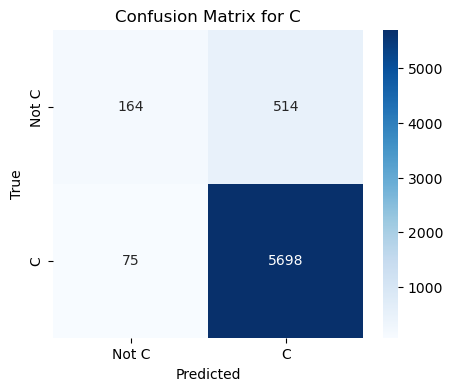


**Vysledky pre triedu M:**
              precision    recall  f1-score   support

       False       0.93      0.93      0.93      5820
        True       0.36      0.36      0.36       631

    accuracy                           0.87      6451
   macro avg       0.64      0.64      0.64      6451
weighted avg       0.87      0.87      0.87      6451



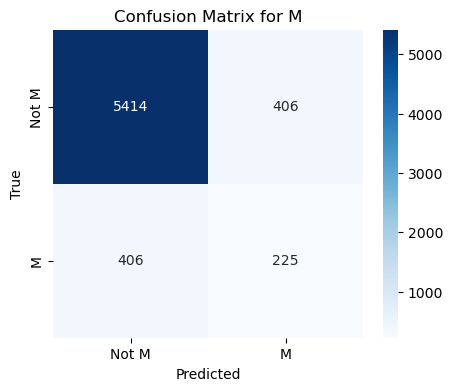


**Vysledky pre triedu X:**
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      6404
        True       0.65      0.51      0.57        47

    accuracy                           0.99      6451
   macro avg       0.82      0.75      0.78      6451
weighted avg       0.99      0.99      0.99      6451



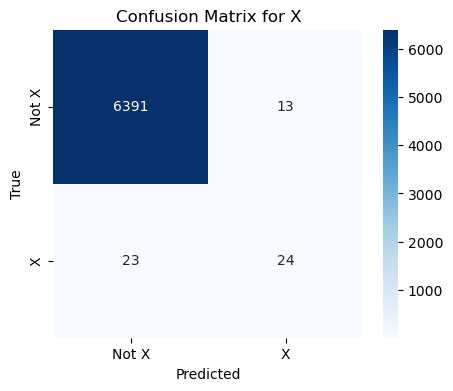

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import expit 

#nacitanie testovacich dat
base_folder = "./ribbons"
test_dir = os.path.join(base_folder, "test")

#  nacitanie ulozeneho modelu
model = load_model("cnn/ribbons_cnn_resnet_sigmoid_thresholds.h5", compile=False)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# generator na normalizaciu a nacitanie obrazkov
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # nezamiesava aby sedeli indexy
)

#  mena tried (C, M, X)
class_labels = list(test_generator.class_indices.keys())
y_true = test_generator.classes

# predikcie z modelu (vystup je sigmoid = pravdepodobnost pre kazdu triedu)
y_pred_prob = model.predict(test_generator)

# najlepsie thresholdy (podla MCC)
best_thresholds = [0.34, 0.33, 0.38]

#  logistic recalibration - trochu posunieme pravdepodobnosti
y_recalibrated = np.zeros_like(y_pred_prob)
for i in range(len(class_labels)):
    p = y_pred_prob[:, i]
    th = best_thresholds[i]
    # aplikujeme sigmoid na logit posunuty o threshold
    y_recalibrated[:, i] = expit(np.log(p / (1 - p + 1e-8)) - np.log(th / (1 - th + 1e-8)))

#  binarizacia rekalibrovanych predikcii (klasifikacia na 0/1)
y_pred_bin = (y_recalibrated > 0.5).astype(int)

# vyhodnotenie pre kazdu triedu zvlast
for i, class_name in enumerate(class_labels):
    print(f"\n**Vysledky pre triedu {class_name}:**")
    print(classification_report(y_true == i, y_pred_bin[:, i]))

    #confusion matrix 
    cm = confusion_matrix(y_true == i, y_pred_bin[:, i])
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not ' + class_name, class_name],
                yticklabels=['Not ' + class_name, class_name])
    plt.title(f'Confusion Matrix for {class_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Vizuálne zobrazenie predikcie konkrétnych prípadov slnečných erupcií s priradenou triedou a levelom pre jednotlivé triedy

Found 6428 images belonging to 3 classes.


/opt/conda/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6428/6428 ━━━━━━━━━━━━━━━━━━━━ 532s 83ms/step


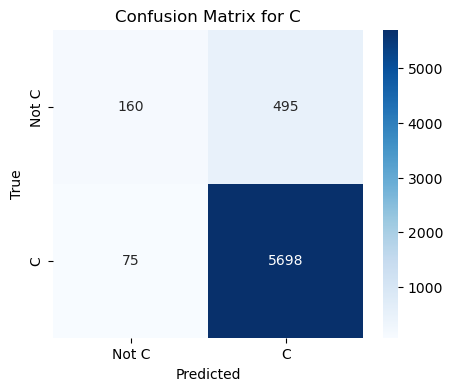

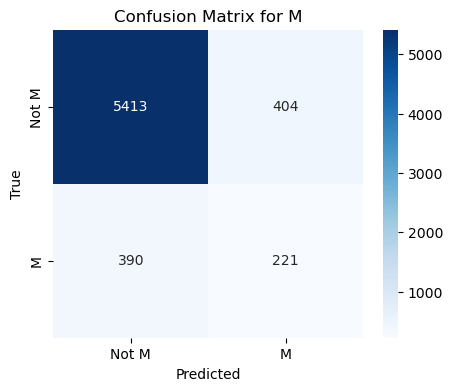

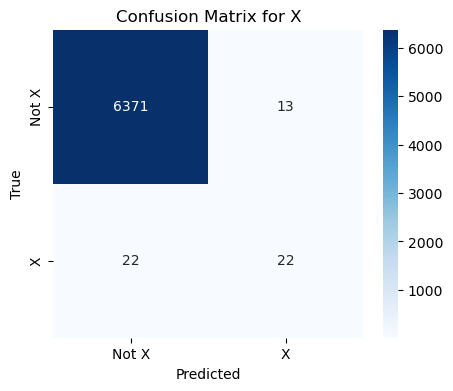

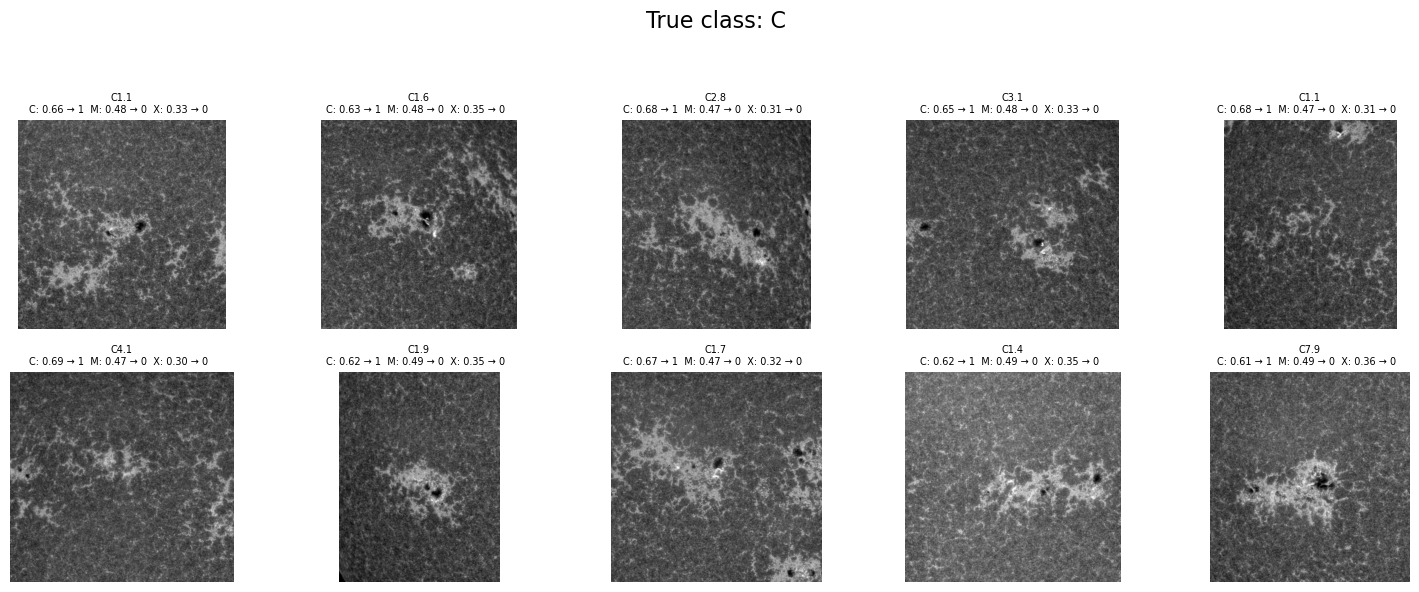

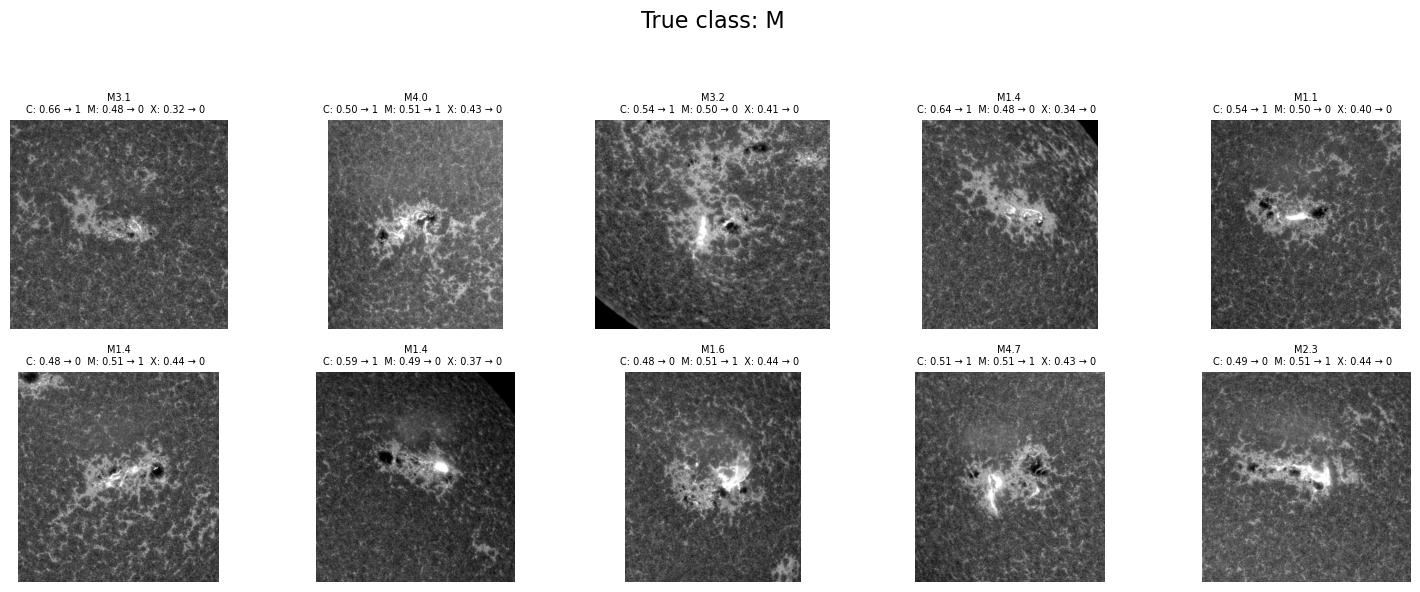

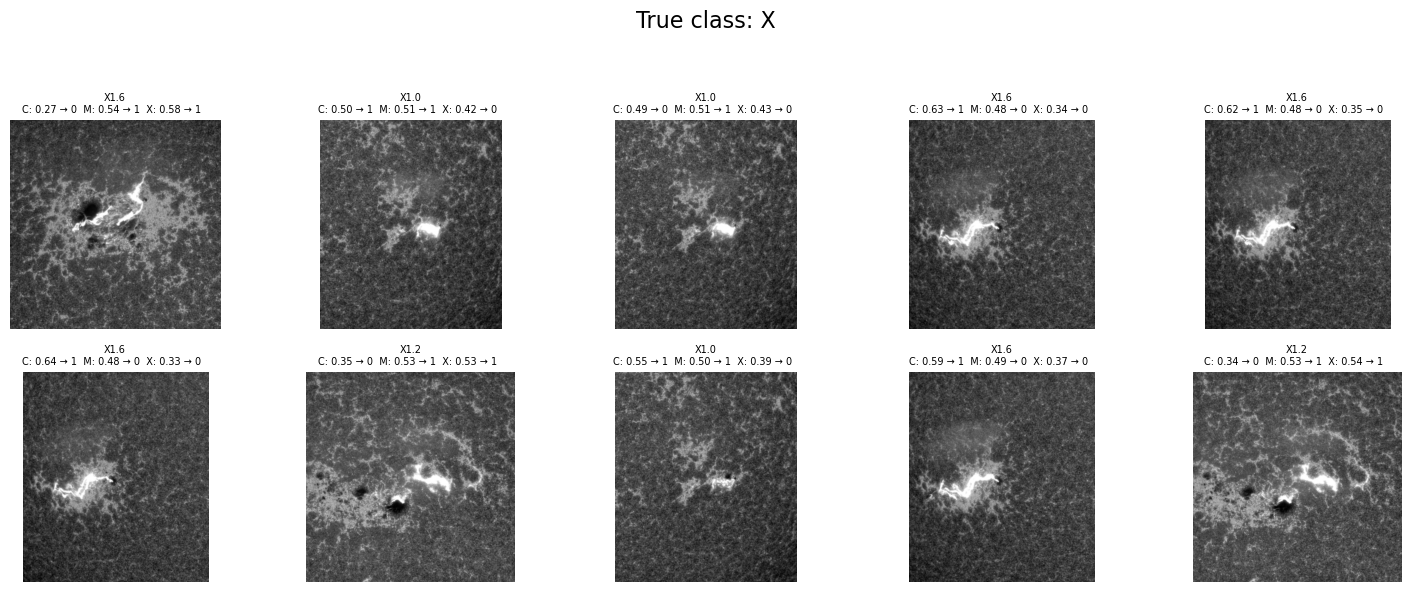

In [7]:
# kniznice
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import expit
import PIL.Image as Image
import random
import pandas as pd
from datetime import datetime

# ======= csv pre urcenie levelov triedy =======
csv_path = "./csv's/ribbondb_v1.0.csv"
df = pd.read_csv(csv_path)
df["TPEAK_DT"] = pd.to_datetime(df[" TPEAK [UT]"])
df["LEVEL"] = df[" KEY"].apply(lambda x: x.split("_")[-1])
df["DATE"] = df["TPEAK_DT"].dt.date
df["CLASS"] = df["LEVEL"].str[0]

# hladanie lvl triedy podla datumu v csv ribbondb_v1.0.csv
def extract_datetime_from_filename(filename):
    base = os.path.basename(filename)
    parts = base.split("_")
    date_str = parts[0]
    time_str = parts[1]
    return datetime.strptime(date_str + time_str, "%Y%m%d%H%M")

def find_closest_flare_level(image_dt, flare_class):
    date = image_dt.date()
    df_filtered = df[(df["DATE"] == date) & (df["CLASS"] == flare_class)]
    if df_filtered.empty:
        return "unknown"
    df_filtered = df_filtered.copy()
    df_filtered["DELTA"] = df_filtered["TPEAK_DT"].apply(lambda t: abs((t - image_dt).total_seconds()))
    closest = df_filtered.sort_values("DELTA").iloc[0]
    if abs((closest["TPEAK_DT"] - image_dt).total_seconds()) <= 5 * 60:
        return closest["LEVEL"]
    return "unknown"

# ======= nacitanie dat a modelu =======
base_folder = "./ribbons"
test_dir = os.path.join(base_folder, "test")

model = load_model("cnn/ribbons_cnn_resnet_sigmoid_thresholds.h5", compile=False)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# test generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical', # viactriedova klasifikacia
    shuffle=False
)

class_labels = list(test_generator.class_indices.keys())
y_pred_prob = model.predict(test_generator)
y_true = test_generator.classes

# optimalizovane tresholdy
best_thresholds = [0.34, 0.33, 0.38]

# rekalibracia p pomocou sigmoid
y_recalibrated = np.zeros_like(y_pred_prob)
for i in range(len(class_labels)):
    curr_threshold = best_thresholds[i]
    logit_pred = np.log(y_pred_prob[:, i] / (1 - y_pred_prob[:, i] + 1e-8))
    logit_thresh = np.log(curr_threshold / (1 - curr_threshold + 1e-8))
    y_recalibrated[:, i] = expit(logit_pred - logit_thresh)

y_pred_thresholded = (y_recalibrated > 0.5).astype(int)

# ======= confusion matrix pre C, M a X=======
for i, class_name in enumerate(class_labels):
    y_true_bin = (y_true == i).astype(int)
    y_pred_bin = y_pred_thresholded[:, i]
    cm = confusion_matrix(y_true_bin, y_pred_bin)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not ' + class_name, class_name],
                yticklabels=['Not ' + class_name, class_name])
    plt.title(f'Confusion Matrix for {class_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# ======= nahodny vyber 10 orbazkov pre kazdu triedu =======
selected_indices = {class_name: [] for class_name in class_labels}
class_to_indices = {class_name: [] for class_name in class_labels}
for i in range(len(y_true)):
    true_class = class_labels[y_true[i]]
    class_to_indices[true_class].append(i)

for class_name, indices in class_to_indices.items():
    selected_indices[class_name] = random.sample(indices, min(10, len(indices)))

# ======= vykreslenie obr =======
for class_name, indices in selected_indices.items():
    num_images = len(indices)
    cols = 5
    rows = (num_images + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
    fig.suptitle(f"True class: {class_name}", fontsize=16)
    axes = axes.flatten()

    for ax_idx, img_idx in enumerate(indices):
        filename = test_generator.filenames[img_idx]
        img_path = os.path.join(test_dir, filename)
        img = Image.open(img_path)

        # predikcie
        pred_probs = y_recalibrated[img_idx]
        pred_labels = (pred_probs > 0.5).astype(int)

        # level triedy podla csv
        img_dt = extract_datetime_from_filename(filename)
        real_level = find_closest_flare_level(img_dt, class_name)

        # zobrazenie obrazka
        axes[ax_idx].imshow(img)
        axes[ax_idx].axis("off")

        # popis
        text = f"{real_level}\n"
        for j, pred_class in enumerate(class_labels):
            text += f"{pred_class}: {pred_probs[j]:.2f} → {pred_labels[j]}  "
        axes[ax_idx].set_title(text, fontsize=7)

    for ax in axes[num_images:]:
        ax.axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

Found 6451 images belonging to 3 classes.


/opt/conda/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6451/6451 ━━━━━━━━━━━━━━━━━━━━ 321s 50ms/step


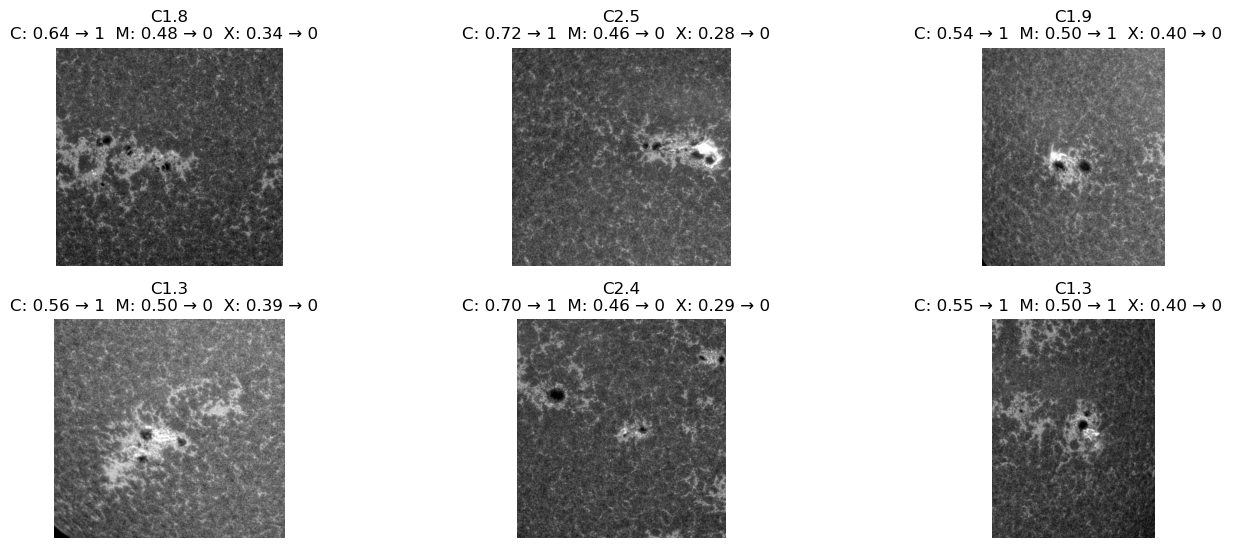

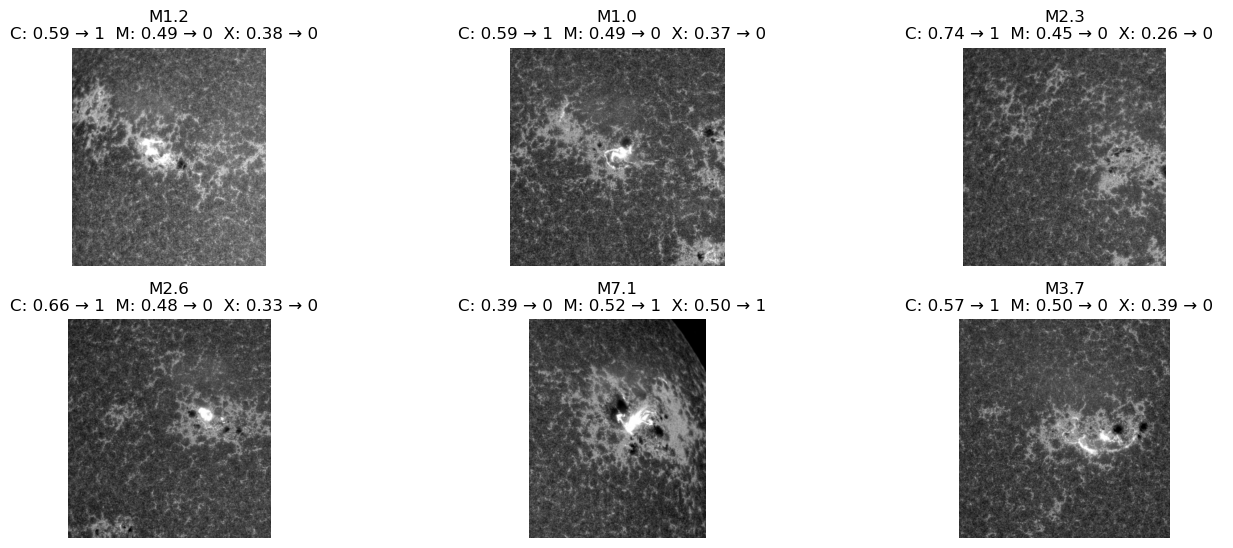

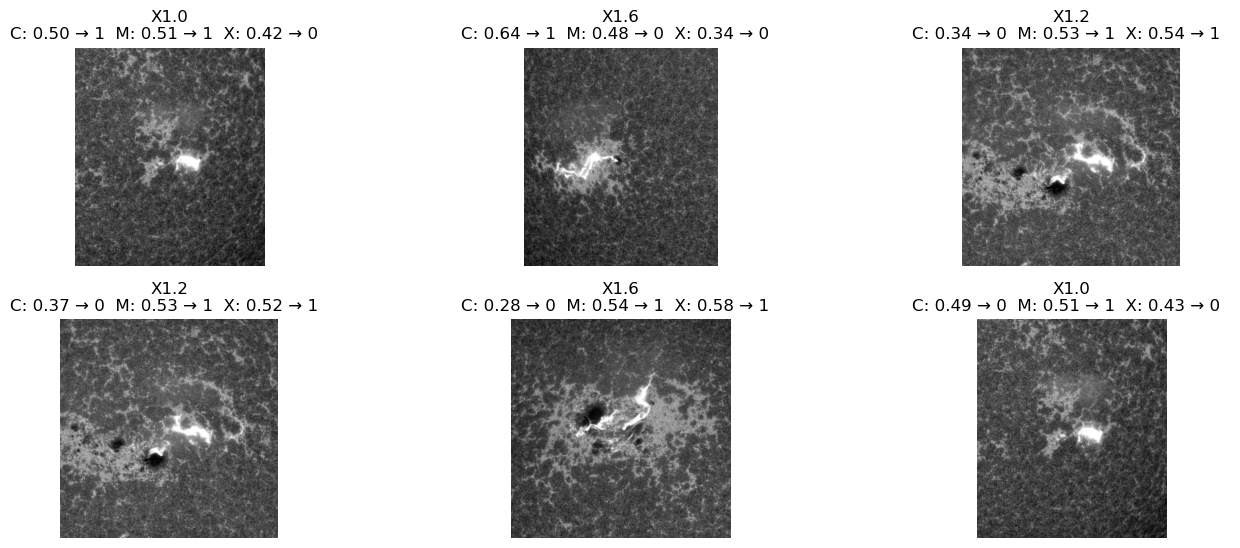

In [10]:
# kniznice
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import expit
import PIL.Image as Image
import random
import pandas as pd
from datetime import datetime

# ======= csv pre urcenie levelov triedy =======
csv_path = "./csv's/ribbondb_v1.0.csv"
df = pd.read_csv(csv_path)
df["TPEAK_DT"] = pd.to_datetime(df[" TPEAK [UT]"])
df["LEVEL"] = df[" KEY"].apply(lambda x: x.split("_")[-1])
df["DATE"] = df["TPEAK_DT"].dt.date
df["CLASS"] = df["LEVEL"].str[0]

# hladanie lvl triedy podla datumu v csv ribbondb_v1.0.csv
def extract_datetime_from_filename(filename):
    base = os.path.basename(filename)
    parts = base.split("_")
    date_str = parts[0]
    time_str = parts[1]
    return datetime.strptime(date_str + time_str, "%Y%m%d%H%M")

def find_closest_flare_level(image_dt, flare_class):
    date = image_dt.date()
    df_filtered = df[(df["DATE"] == date) & (df["CLASS"] == flare_class)]
    if df_filtered.empty:
        return "unknown"
    df_filtered = df_filtered.copy()
    df_filtered["DELTA"] = df_filtered["TPEAK_DT"].apply(lambda t: abs((t - image_dt).total_seconds()))
    closest = df_filtered.sort_values("DELTA").iloc[0]
    if abs((closest["TPEAK_DT"] - image_dt).total_seconds()) <= 5 * 60:
        return closest["LEVEL"]
    return "unknown"

# ======= nacitanie dat a modelu =======
base_folder = "./ribbons"
test_dir = os.path.join(base_folder, "test")
# vytvor výstupný priečinok (iba raz)
output_dir = "outputsData"
os.makedirs(output_dir, exist_ok=True)

model = load_model("cnn/ribbons_cnn_resnet_sigmoid_thresholds.h5", compile=False)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# test generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical', # viactriedova klasifikacia
    shuffle=False
)

class_labels = list(test_generator.class_indices.keys())
y_pred_prob = model.predict(test_generator)
y_true = test_generator.classes

# optimalizovane tresholdy
best_thresholds = [0.34, 0.33, 0.38]

# rekalibracia p pomocou sigmoid
y_recalibrated = np.zeros_like(y_pred_prob)
for i in range(len(class_labels)):
    curr_threshold = best_thresholds[i]
    logit_pred = np.log(y_pred_prob[:, i] / (1 - y_pred_prob[:, i] + 1e-8))
    logit_thresh = np.log(curr_threshold / (1 - curr_threshold + 1e-8))
    y_recalibrated[:, i] = expit(logit_pred - logit_thresh)

y_pred_thresholded = (y_recalibrated > 0.5).astype(int)

# ======= nahodny vyber 6 orbazkov pre kazdu triedu =======
selected_indices = {class_name: [] for class_name in class_labels}
class_to_indices = {class_name: [] for class_name in class_labels}
for i in range(len(y_true)):
    true_class = class_labels[y_true[i]]
    class_to_indices[true_class].append(i)

for class_name, indices in class_to_indices.items():
    selected_indices[class_name] = random.sample(indices, min(6, len(indices)))

# ======= vykreslenie obr =======
for class_name, indices in selected_indices.items():
    num_images = len(indices)
    cols = 3
    rows = (num_images + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
    #fig.suptitle(f"True class: {class_name}", fontsize=16)
    axes = axes.flatten()

    for ax_idx, img_idx in enumerate(indices):
        filename = test_generator.filenames[img_idx]
        img_path = os.path.join(test_dir, filename)
        img = Image.open(img_path)

        # predikcie
        pred_probs = y_recalibrated[img_idx]
        pred_labels = (pred_probs > 0.5).astype(int)

        # level triedy podla csv
        img_dt = extract_datetime_from_filename(filename)
        real_level = find_closest_flare_level(img_dt, class_name)

        # zobrazenie obrazka
        axes[ax_idx].imshow(img)
        axes[ax_idx].axis("off")

        # popis
        text = f"{real_level}\n"
        for j, pred_class in enumerate(class_labels):
            text += f"{pred_class}: {pred_probs[j]:.2f} → {pred_labels[j]}  "
        axes[ax_idx].set_title(text, fontsize=12)

    for ax in axes[num_images:]:
        ax.axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    # vo vnútri cyklu, tesne pred plt.show()
    output_path = os.path.join(output_dir, f"vizualne_predikcie_{class_name}.png")
    #plt.savefig(output_path, dpi=300)
    plt.show()

confusion matrix so snimkami erupcii

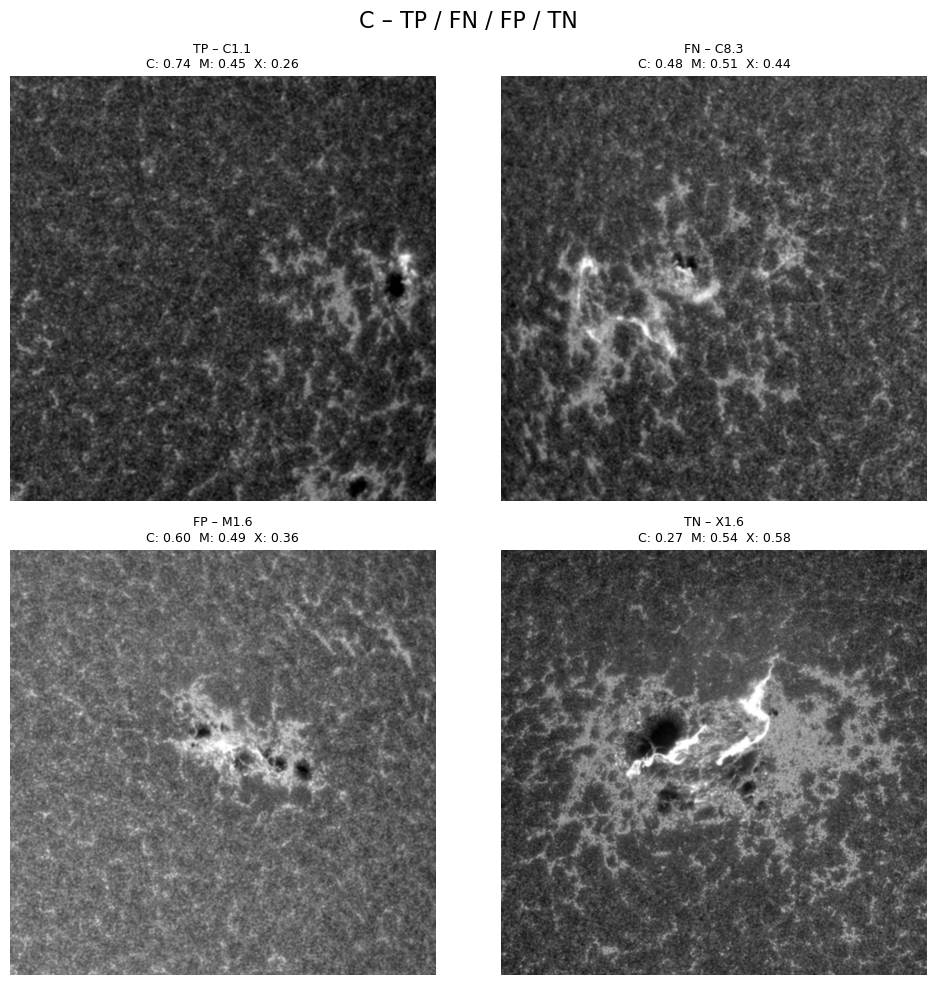

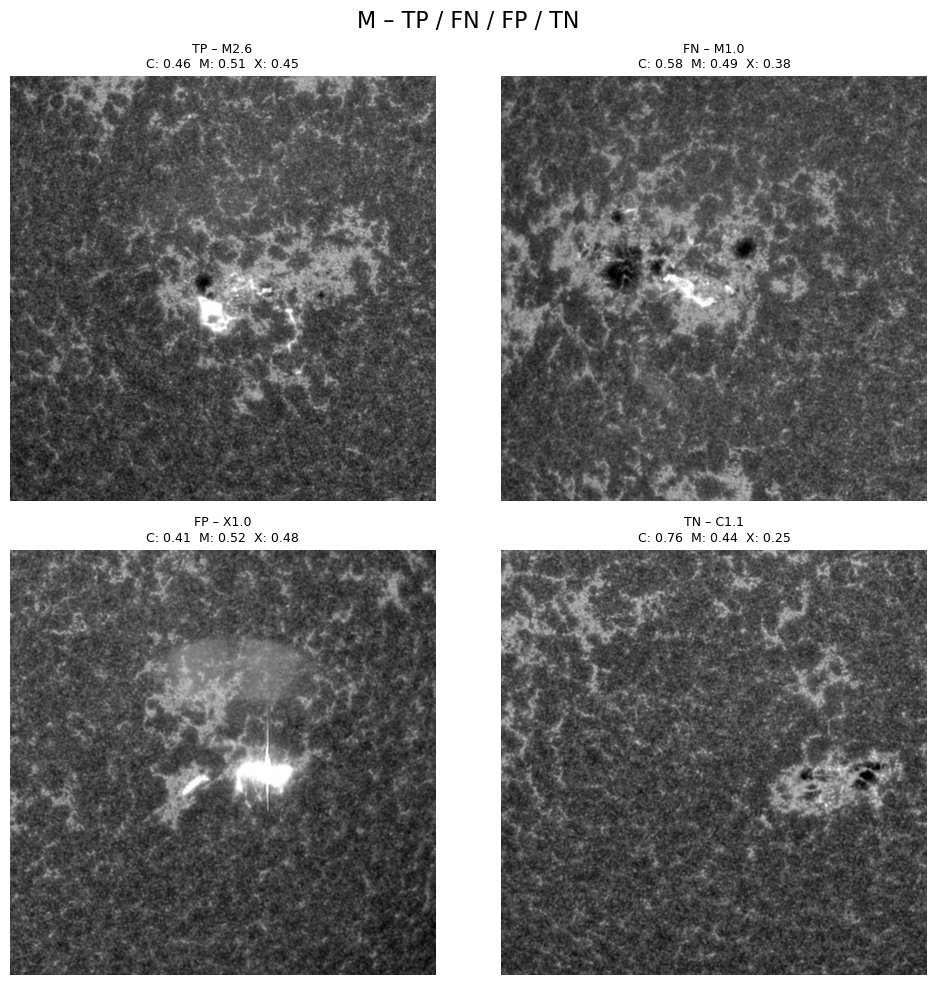

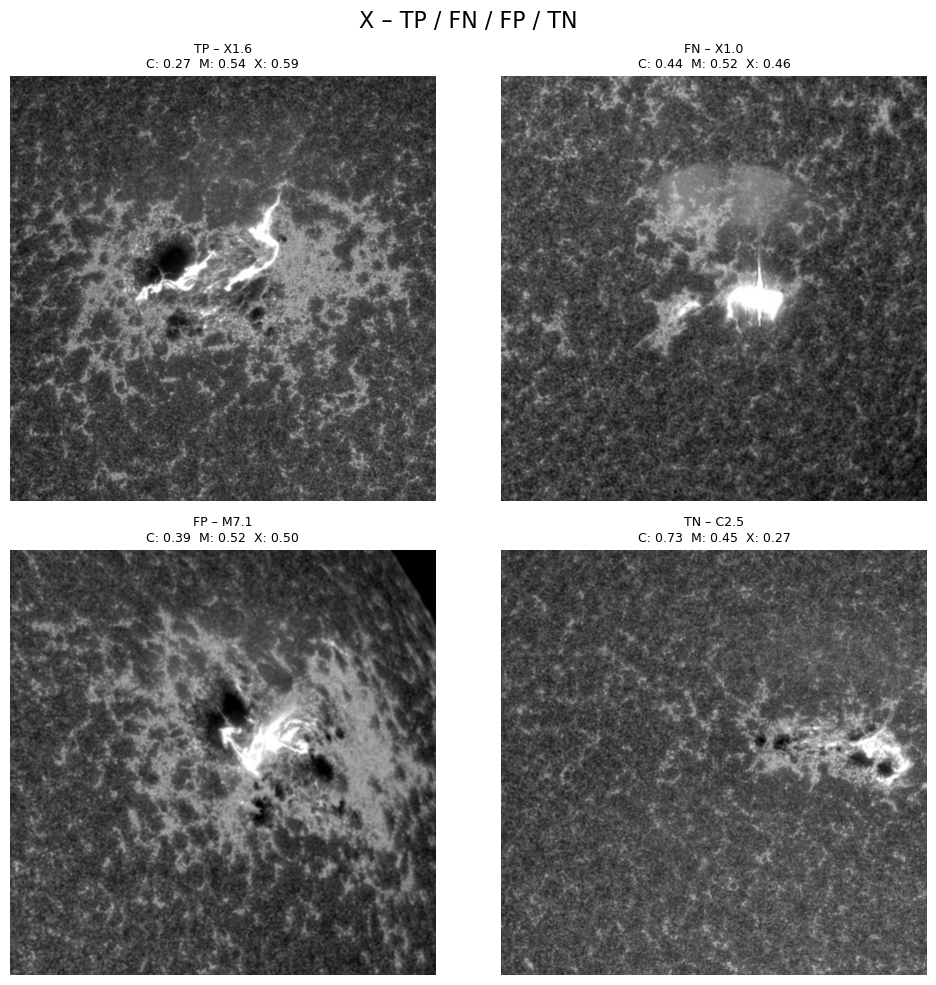

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import PIL.Image as Image
import os

df = pd.read_csv("predictions_summary.csv")

# cesta k priecinkom
test_dir = "./ribbons/test"
output_dir = "./outputsPredictions"
os.makedirs(output_dir, exist_ok=True)

# konkretne pripady pre kazdu triedu
image_cases = {
    "C": {
        "TP": "C/20160115_2200_C_cutout.png",
        "FN": "C/20130830_0241_C_cutout.png",
        "FP": "M/20110216_1421_M_cutout.png",
        "TN": "X/20141022_1426_X_cutout.png"
    },
    "M": {
        "TP": "M/20140202_0636_M_cutout.png",
        "FN": "M/20140201_0128_M_cutout.png",
        "FP": "X/20140329_1746_X_cutout.png",
        "TN": "C/20130409_2035_C_cutout.png"
    },
    "X": {
        "TP": "X/20141022_1423_X_cutout.png",
        "FN": "X/20140329_1747_X_cutout.png",
        "FP": "M/20141027_0036_M_cutout.png",
        "TN": "C/20120702_1938_C_cutout.png"
    }
}

from PIL import ImageOps

# nacitanie velkosti, uprava na jednotny tvar
def load_and_resize_image(path, size=(2048, 2048)):
    try:
        img = Image.open(path).convert("L")  # grayscale
        img = ImageOps.fit(img, size, Image.LANCZOS)
        return img
    except:
        return None

# vykreslenie obr s jednotnou velkostou
for class_label, cases in image_cases.items():
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    fig.suptitle(f"{class_label} – TP / FN / FP / TN", fontsize=16)
    axes = axes.flatten()

    for ax, (case_label, file_path) in zip(axes, cases.items()):
        full_path = os.path.join(test_dir, file_path)

        # hladanie dat
        match = df[df["file"] == file_path]
        if match.empty:
            ax.set_title(f"{case_label}: nevie najst", fontsize=9)
            ax.axis("off")
            continue

        row = match.iloc[0]
        img = load_and_resize_image(full_path)

        if img is None:
            ax.set_title(f"{case_label}: chyba", fontsize=9)
            ax.axis("off")
            continue

        ax.imshow(img, cmap="gray", aspect='auto')
        ax.axis("off")
        ax.set_box_aspect(1)  # stvorce

        text = f"{case_label} – {row['class']}\n"
        text += f"C: {row['C_prob']:.2f}  M: {row['M_prob']:.2f}  X: {row['X_prob']:.2f}"
        ax.set_title(text, fontsize=9)

    plt.subplots_adjust(top=0.88)
    plt.tight_layout()
    out_path = os.path.join(output_dir, f"{class_label}_TP_FN_FP_TN.png")
    plt.savefig(out_path)
    plt.show()

# Tabuľka všetkých predikcií

In [9]:
import pandas as pd

# zozbieranie vysledkov
records = []

for i in range(len(y_true)):
    filename = test_generator.filenames[i]
    pred_probs = y_recalibrated[i]  # pravdepodobnosti po rekalibracii
    pred_labels = (pred_probs > 0.5).astype(int)
    true_class_idx = y_true[i]
    true_class = class_labels[true_class_idx]

    # ziskanie datetime a flare level
    img_dt = extract_datetime_from_filename(filename)
    flare_level = find_closest_flare_level(img_dt, true_class)

    # zistenie ci je predikcia spravna
    predicted_classes = [class_labels[j] for j in range(len(class_labels)) if pred_labels[j] == 1]
    correct = true_class in predicted_classes

    # vytvorenie zzoznamu
    record = {
        "file": filename,
        "pred": ",".join([class_labels[j] for j in range(len(class_labels)) if pred_labels[j] == 1]),
        "true": true_class,
        "class": flare_level,
        "C_prob": round(pred_probs[class_labels.index("C")], 2),
        "M_prob": round(pred_probs[class_labels.index("M")], 2),
        "X_prob": round(pred_probs[class_labels.index("X")], 2),
        "correct": correct
    }

    records.append(record)

# dataframe -> export do csv
df_predictions = pd.DataFrame(records)
df_predictions.to_csv("predictions_summary.csv", index=False)
print("predikcie boli ulozebe")


predikcie boli ulozebe


In [4]:
import pandas as pd

df = pd.read_excel("predictions_summary.xlsx")  

df.to_csv("predictions_summary", index=False)

print("Excel bol konvertovaný na CSV.")

Excel bol konvertovaný na CSV.


doplnenie chybajucich hodnot 

In [5]:
import os
import pandas as pd
import random
from datetime import datetime, timedelta

# cesty
test_dir = "./ribbons/test"
csv_path = "./csv's/ribbondb_v1.0.csv"

# načítanie CSV
df = pd.read_csv(csv_path)
df["TPEAK_DT"] = pd.to_datetime(df[" TPEAK [UT]"])  # pre porovnávanie s obrázkami
df["LEVEL"] = df[" KEY"].apply(lambda x: x.split("_")[-1])  
df["DATE"] = df["TPEAK_DT"].dt.date
df["CLASS"] = df["LEVEL"].str[0]  # M / X / C

# zoznam všetkých obrázkov v testovacom adresári
image_paths = []
for class_dir in os.listdir(test_dir):
    full_dir = os.path.join(test_dir, class_dir)
    if os.path.isdir(full_dir):
        for fname in os.listdir(full_dir):
            if fname.endswith(".png"):
                image_paths.append((class_dir, os.path.join(full_dir, fname)))

# triedenie obrázkov podľa triedy
images_by_class = {"C": [], "M": [], "X": []}
for cls, path in image_paths:
    if cls in images_by_class:
        images_by_class[cls].append(path)

# funkcia: získa datetime z názvu obrázka
def extract_datetime_from_filename(filename):
    base = os.path.basename(filename)
    parts = base.split("_")
    date_str = parts[0]
    time_str = parts[1]
    return datetime.strptime(date_str + time_str, "%Y%m%d%H%M")

# funkcia: nájde najbližší PEAK čas v CSV pre danú triedu a dátum
def find_closest_flare_level(image_dt, flare_class):
    date = image_dt.date()
    df_filtered = df[(df["DATE"] == date) & (df["CLASS"] == flare_class)]
    if df_filtered.empty:
        return "unknown"

    # najdeme najbližší záznam podľa rozdielu v čase
    df_filtered["DELTA"] = df_filtered["TPEAK_DT"].apply(lambda t: abs((t - image_dt).total_seconds()))
    closest = df_filtered.sort_values("DELTA").iloc[0]
    if abs((closest["TPEAK_DT"] - image_dt).total_seconds()) <= 5 * 60:
        return closest["LEVEL"]
    return "unknown"

# vypis 10 náhodných obrázkov z každej triedy s priradenou úrovňou triedy
for class_name, paths in images_by_class.items():
    print(f"\nTrieda: {class_name}")
    sampled_paths = random.sample(paths, min(10, len(paths)))
    for path in sampled_paths:
        img_dt = extract_datetime_from_filename(path)
        level = find_closest_flare_level(img_dt, class_name)
        print(f"{os.path.basename(path)} → čas: {img_dt.strftime('%Y-%m-%d %H:%M')} → priradená trieda: {level}")



Trieda: C
20120308_1626_C_cutout.png → čas: 2012-03-08 16:26 → priradená trieda: C1.1
20141219_2138_C_cutout.png → čas: 2014-12-19 21:38 → priradená trieda: C1.7
20140214_1039_C_cutout.png → čas: 2014-02-14 10:39 → priradená trieda: C7.2
20120118_2323_C_cutout.png → čas: 2012-01-18 23:23 → priradená trieda: C5.1
20111113_1643_C_cutout.png → čas: 2011-11-13 16:43 → priradená trieda: C1.2
20131012_0342_C_cutout.png → čas: 2013-10-12 03:42 → priradená trieda: C5.4
20160115_0239_C_cutout.png → čas: 2016-01-15 02:39 → priradená trieda: C2.8
20120308_1618_C_cutout.png → čas: 2012-03-08 16:18 → priradená trieda: C1.1
20120730_0828_C_cutout.png → čas: 2012-07-30 08:28 → priradená trieda: C2.1
20130421_0921_C_cutout.png → čas: 2013-04-21 09:21 → priradená trieda: C2.5

Trieda: M
20140201_0123_M_cutout.png → čas: 2014-02-01 01:23 → priradená trieda: M1.0
20150130_0040_M_cutout.png → čas: 2015-01-30 00:40 → priradená trieda: M2.0
20111225_1811_M_cutout.png → čas: 2011-12-25 18:11 → priradená tri

/tmp/ipykernel_28/1682597503.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["DELTA"] = df_filtered["TPEAK_DT"].apply(lambda t: abs((t - image_dt).total_seconds()))
/tmp/ipykernel_28/1682597503.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["DELTA"] = df_filtered["TPEAK_DT"].apply(lambda t: abs((t - image_dt).total_seconds()))
/tmp/ipykernel_28/1682597503.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i